In [7]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, MaxPooling1D, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

data = pd.read_csv("Datasets/SPY_30years.csv",
                   index_col="Date", parse_dates=True)


In [8]:
data.info()
# data.drop(['Dividends', 'Stock Splits', "Capital Gains"], axis=1, inplace=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7263 entries, 1994-01-27 to 2022-11-30
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Open               7263 non-null   float64
 1   High               7263 non-null   float64
 2   Low                7263 non-null   float64
 3   Close              7263 non-null   float64
 4   Adj Close          7263 non-null   float64
 5   Volume             7263 non-null   int64  
 6   SMA_5              7263 non-null   float64
 7   SMA_20             7263 non-null   float64
 8   SMA_50             7263 non-null   float64
 9   SMA_252            7263 non-null   float64
 10  daily_return       7263 non-null   float64
 11  monthly_return     7263 non-null   float64
 12  adv20              7263 non-null   float64
 13  VWAP               7263 non-null   float64
 14  log_returns        7263 non-null   float64
 15  volatility_30      7263 non-null   float64
 16  volati

In [19]:
row = pd.DataFrame(df.iloc[-1, :]).transpose()
(row['SMA_5'] > row['SMA_20']).index


DatetimeIndex(['2023-01-03'], dtype='datetime64[ns]', freq=None)

In [3]:


df = data['Close']
#print(df.values)
dataset = df.values.reshape(-1, 1)
training_data_len = int(np.ceil(len(dataset) * .95))

training_data_len

dataset.shape

(7263, 1)

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)




In [5]:
train, test = scaled_data[0:int(
    len(dataset) * 0.7), :], scaled_data[int(len(dataset) * 0.7): , :]


In [6]:
def reconstruct_data(data, n=1):
    data = pd.DataFrame(data)
    x, y = [], []
    for i in range(len(data) - n - 1):
        x.append(data.iloc[i:(i + n), :])
        # append close price
        y.append(data.iloc[i + n, 0])

    return (np.array(x), np.array(y))


train_x, train_y = reconstruct_data(train, 5)
test_x, test_y = reconstruct_data(test, 5)
print(train_x.shape, train_y.shape)


(5078, 5, 1) (5078,)


In [7]:
from keras import callbacks
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)


def model_lstm(window, features):

    # current best
    model4 = Sequential()
    model4.add(LSTM(300, input_shape=(window, features), return_sequences=True))
    model4.add(Dropout(0.5))
    model4.add(LSTM(200, input_shape=(window, features), return_sequences=True))
    model4.add(Dropout(0.5))
    model4.add(LSTM(100, input_shape=(window, features), return_sequences=False))
    model4.add(Dropout(0.5))
    model4.add(Dense(1))
    model4.compile(loss='mse', optimizer='adam')

    # test model
    model = Sequential()
    model.add(LSTM(100, input_shape=(window, features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(50, input_shape=(window, features), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(25, input_shape=(window, features), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # from kaggle
    model2 = Sequential()
    model2.add(LSTM(128, return_sequences=True,
               input_shape=(window, features)))
    model2.add(LSTM(64, return_sequences=False))
    model2.add(Dense(25))
    model2.add(Dense(1))
    model2.compile(loss='mse', optimizer='adam', metrics = ['mean_squared_error'])

    return model2

    # return model4


earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=10,
                                        restore_best_weights=True)


In [8]:

epochs = [50,100]
batch_sizes = [12, 24]
results = {
    "epoch": [],
    "batch_size": [],
    "score": []
}

for batch_size in batch_sizes:
    for epoch in epochs:
        score_tracking = []
        for train_index, val_index in tscv.split(train):
            model = model_lstm(5, 1)

            train_data, val_data = train[:max(train_index)], train[max(train_index):]

            train_data_x, train_data_y = reconstruct_data(train_data, 5)
            val_data_x, val_data_y = reconstruct_data(val_data, 5)
            #print(train_data_x.shape, train_data_y.shape)

            train_data_x = np.reshape(
                train_data_x, (train_data_x.shape[0], train_data_x.shape[1], 1))
            val_data_x = np.reshape(
                val_data_x, (val_data_x.shape[0], val_data_x.shape[1], 1))

            model.fit(train_data_x, train_data_y, epochs=epoch, batch_size=batch_size,
                        validation_data=(val_data_x, val_data_y),
                        verbose=0, callbacks=[], shuffle=False)
            
            test_loss = model.evaluate(test_x, test_y)
            score_tracking.append(test_loss)
            
        Mean_Squared_Error = np.mean(score_tracking)
        results["epoch"].append(epoch)
        results["batch_size"].append(batch_size)
        results["score"].append(Mean_Squared_Error)
        #Append to dataframe
        #params = pd.concat([params, pd.DataFrame({'batch_size': batch_size, 'epoch': epoch, 'score': Mean_Squared_Error})],
        #                   axis=0)


# Get Best Params individual
params = pd.DataFrame(results).sort_values(by=['score'], ascending=True, inplace=True, ignore_index=True)
params.head(10)


68/68 [==============================] - 0s 3ms/step - loss: 0.0937 - mean_squared_error: 0.0937


AttributeError: 'NoneType' object has no attribute 'head'

Epoch 1/100
212/212 - 6s - loss: 8.5876e-04 - mean_squared_error: 8.5876e-04 - 6s/epoch - 30ms/step
Epoch 2/100
212/212 - 2s - loss: 2.5818e-05 - mean_squared_error: 2.5818e-05 - 2s/epoch - 8ms/step
Epoch 3/100
212/212 - 2s - loss: 2.6706e-05 - mean_squared_error: 2.6706e-05 - 2s/epoch - 8ms/step
Epoch 4/100
212/212 - 2s - loss: 2.7735e-05 - mean_squared_error: 2.7735e-05 - 2s/epoch - 9ms/step
Epoch 5/100
212/212 - 2s - loss: 2.5573e-05 - mean_squared_error: 2.5573e-05 - 2s/epoch - 9ms/step
Epoch 6/100
212/212 - 2s - loss: 2.5099e-05 - mean_squared_error: 2.5099e-05 - 2s/epoch - 9ms/step
Epoch 7/100
212/212 - 2s - loss: 2.5171e-05 - mean_squared_error: 2.5171e-05 - 2s/epoch - 10ms/step
Epoch 8/100
212/212 - 2s - loss: 2.9818e-05 - mean_squared_error: 2.9818e-05 - 2s/epoch - 9ms/step
Epoch 9/100
212/212 - 2s - loss: 2.6810e-05 - mean_squared_error: 2.6810e-05 - 2s/epoch - 9ms/step
Epoch 10/100
212/212 - 2s - loss: 2.9967e-05 - mean_squared_error: 2.9967e-05 - 2s/epoch - 9ms/step
Epoch 1

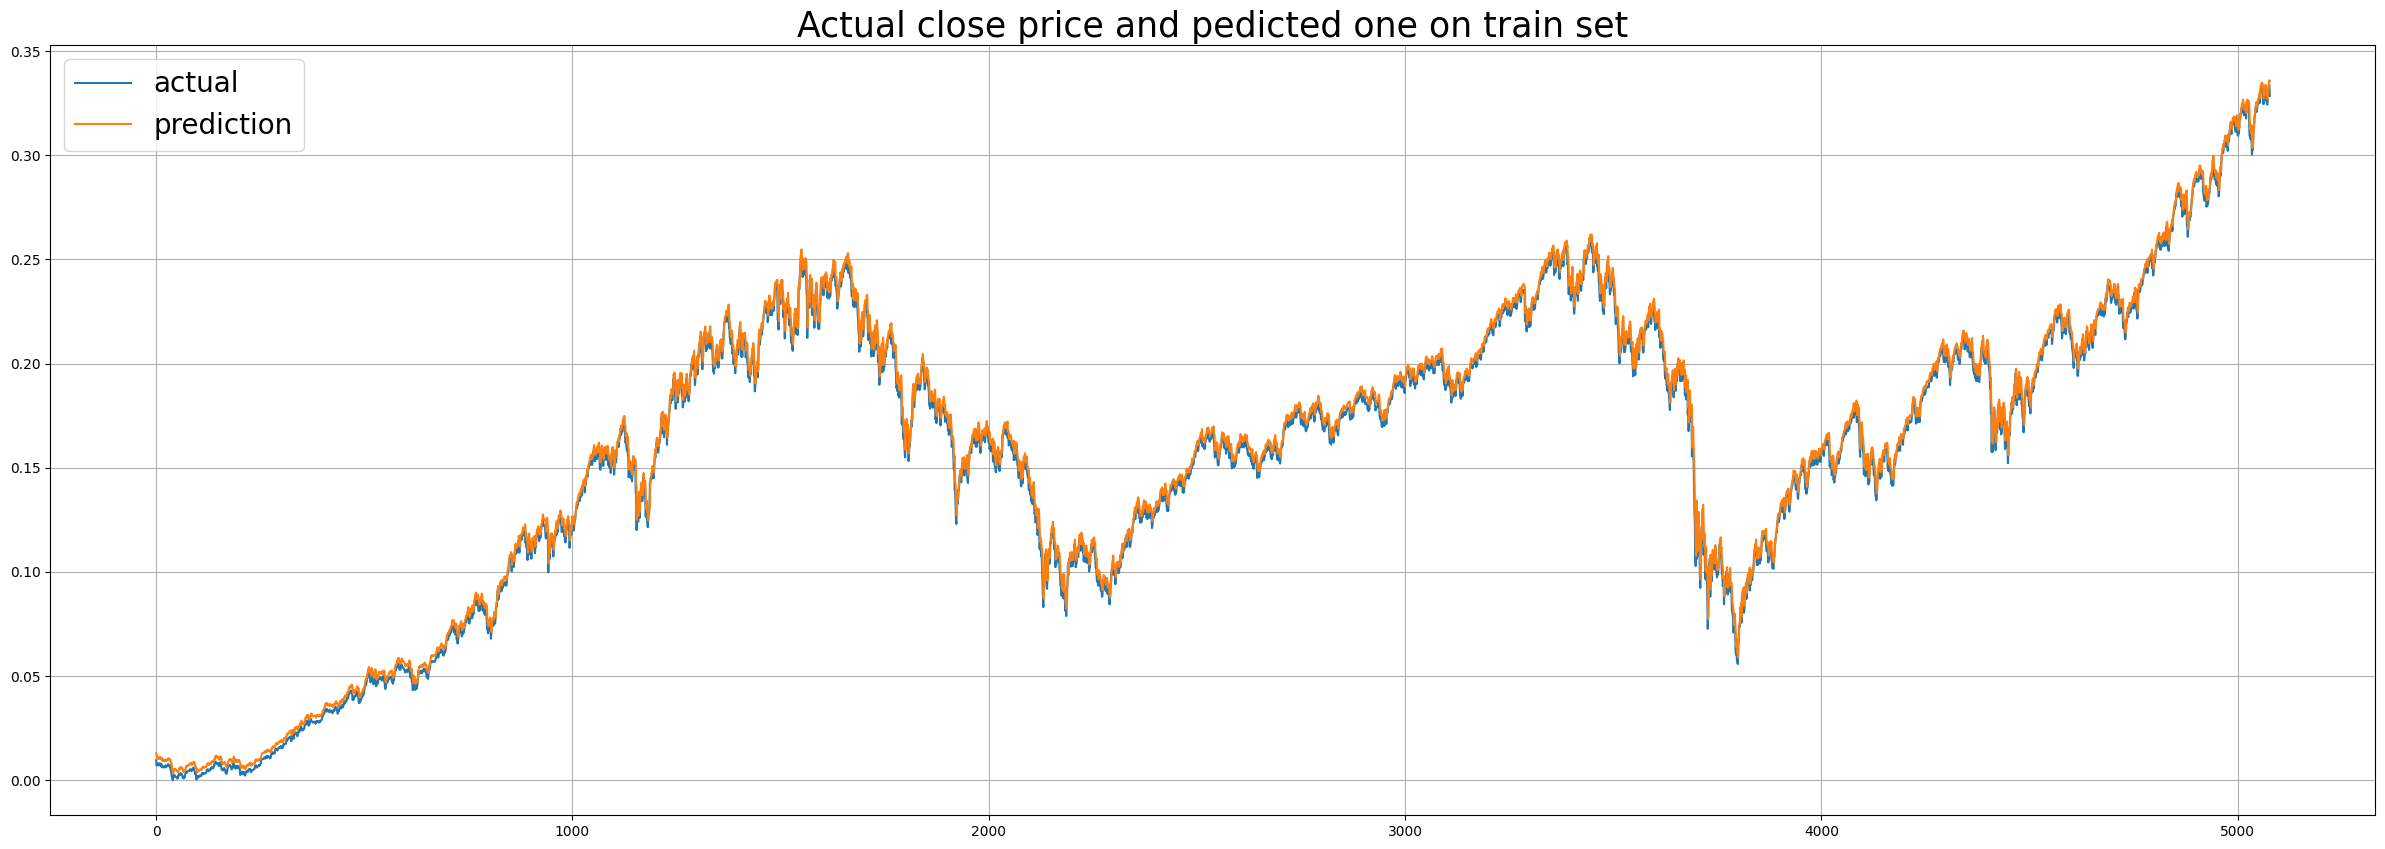

In [ ]:
#Constructing final model using best params
model = model_lstm(5, 1)
train_x = np.reshape(train_x, (train_x.shape[0],  train_x.shape[1], 1))
test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

history = model.fit(
    train_x, train_y, epochs=int(params.iloc[0, 1]), batch_size=int(params.iloc[0, 0]), verbose=2)

y_predicted = model.predict(train_x)



# unscaled_predicted = scaler.inverse_transform(y_predicted)

plt.figure(figsize=(30, 10))
plt.plot(train_y, label="actual")
plt.plot(y_predicted, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual close price and pedicted one on train set", fontsize=25)
plt.show()


68/68 [==============================] - 0s 3ms/step
(2173, 5, 1)


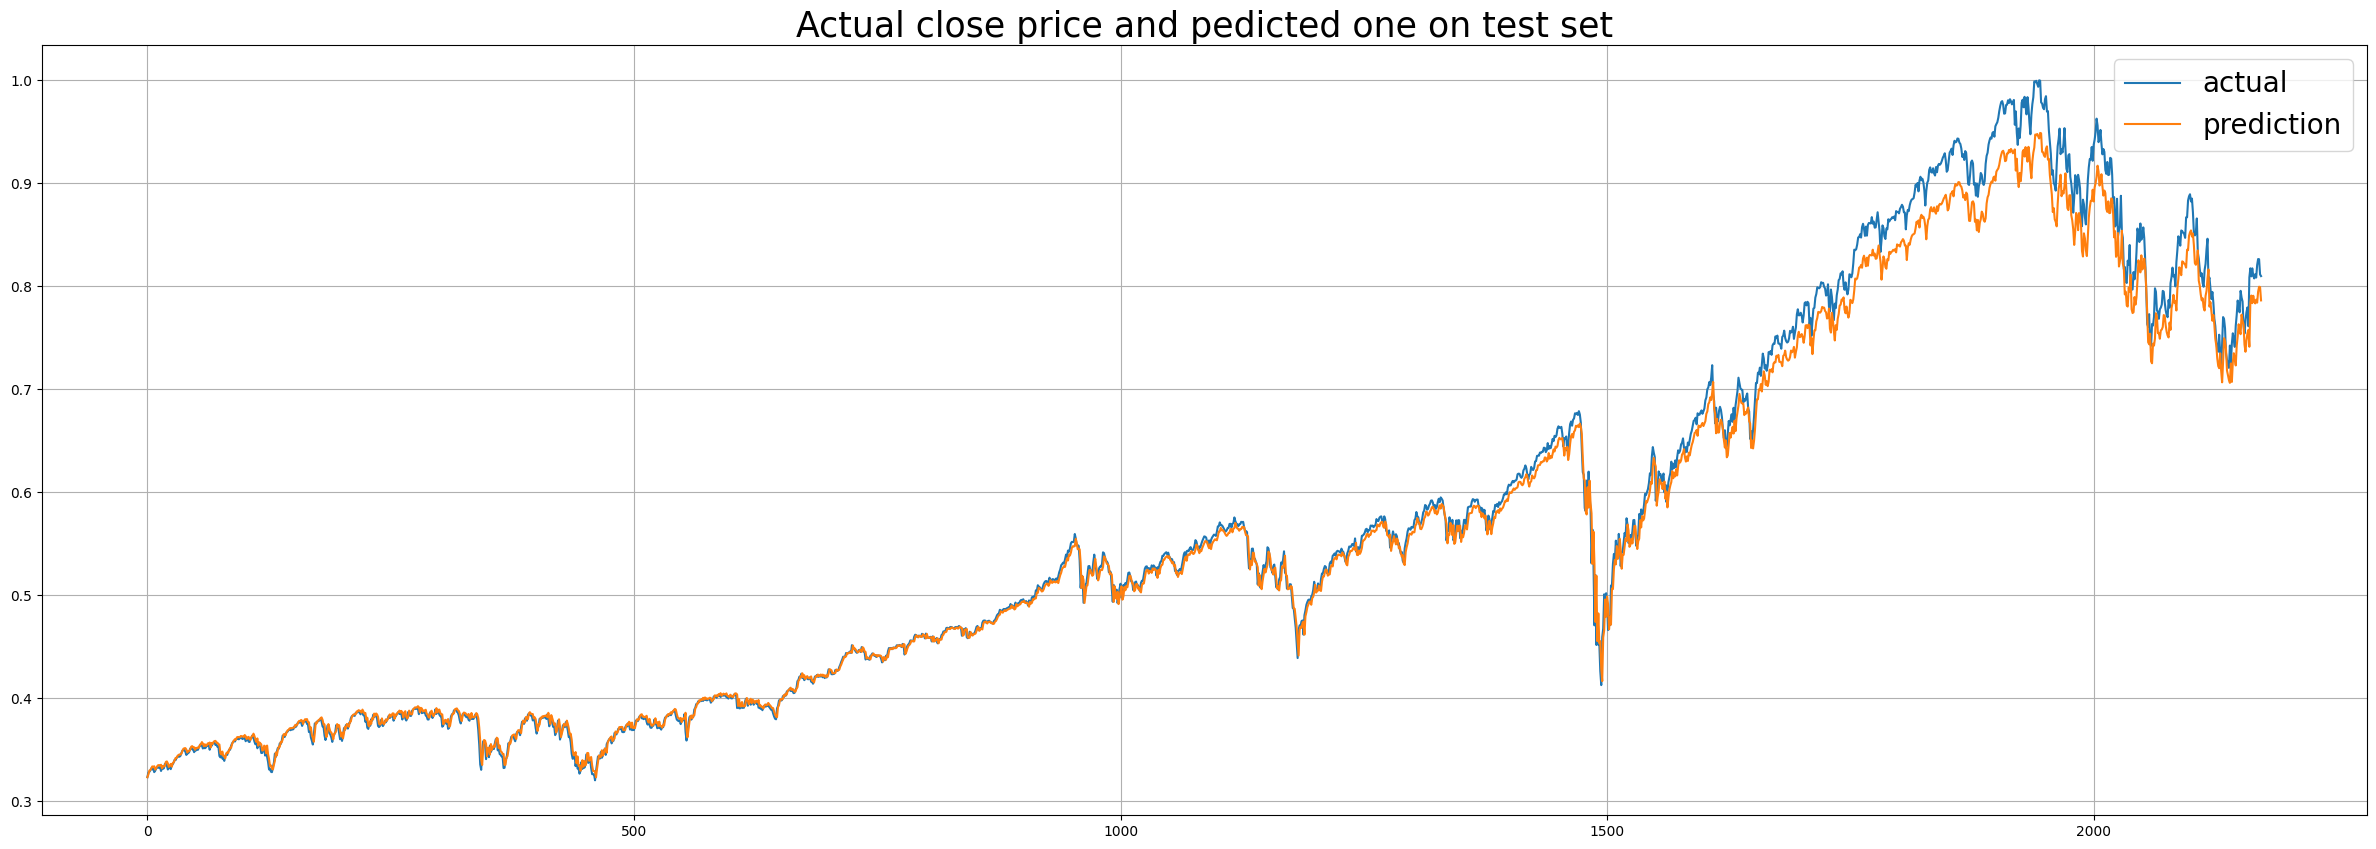

In [ ]:
# Predicting Testing Dataset
test_predict = model.predict(test_x)
print(test_x.shape)
#print(test_predict)
# test_predict = scaler.inverse_transform(test_predict)
# test_labels = scaler.inverse_transform(test_y)

plt.figure(figsize=(30, 10))
plt.plot(test_y, label="actual")
plt.plot(test_predict, label="prediction")
plt.legend(fontsize=20)
plt.grid(axis="both")
plt.title("Actual close price and pedicted one on test set", fontsize=25)
plt.show()


In [ ]:

predictions = scaler.inverse_transform(test_predict)
print(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - test) ** 2)))
rmse


[[184.1342 ]
 [185.28085]
 [186.94052]
 ...
 [390.74857]
 [390.60803]
 [384.99292]]


ValueError: operands could not be broadcast together with shapes (2173,1) (2179,1) 

In [ ]:
# Plot the data
train = data[:int(
    len(dataset) * 0.7)]
valid = data[int(
    len(dataset) * 0.7):]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16, 6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()


ValueError: Length of values (2173) does not match length of index (2179)